In [1]:
from pyspark.sql import functions as sparkf

In [2]:
import time as t
start_time = t.time()

### 1. Business Understanding

Problem Statement:  Prediction of Arrival Delay

Project Objective: (1) Regression Model (2) Model Deployment

### 2. Data Understanding

#### Spark อ่านไฟล์ 2008.csv จาก HDFS มาเป็น DataFrame

In [3]:
airline_df = spark.read\
.parquet('/rawzone/*')

#### Spark นับจำนวน tuple ใน DataFrame

In [4]:
airline_df.count()

70321

#### Spark: Assign ค่าของตัวแปรเก่า ให้กับตัวแปรใหม่

In [5]:
airline_row_df = airline_df.filter(sparkf.col('Cancelled') != 1)

In [6]:
airline_row_df.count()

68936

#### Spark แสดง Schema ของข้อมูลใน DataFrame

In [7]:
airline_row_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

In [8]:
airline_row_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Year,68936,2008.0,0.0,2008,2008
Month,68936,6.40627538586515,3.402635403534994,1,12
DayofMonth,68936,15.671739004293837,8.787066910469713,1,31
DayOfWeek,68936,3.9220436346756413,1.9832001399964,1,7
DepTime,68936,1332.1209237553674,478.1508810626554,1,959
CRSDepTime,68936,1323.6930486248114,464.05574564694814,1,2359
ArrTime,68936,1477.3613194929053,505.7453617691981,1,NA
CRSArrTime,68936,1491.8013374724383,482.2870571433784,1,2400
UniqueCarrier,68936,None,None,9E,YV


### 3. Data Preparation

#### Spark เรียกใช้ Data Types และ Functions ต่างๆ สำหรับจัดการข้อมูลใน DataFrame

In [9]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf

In [10]:
crunched_df = airline_row_df.\
withColumn('DepTime',airline_row_df['DepTime'].\
           cast(DoubleType())).\
withColumn('TaxiOut',airline_row_df['TaxiOut'].\
           cast(DoubleType())).\
withColumn('TaxiIn',airline_row_df['TaxiIn'].\
           cast(DoubleType())).\
withColumn('DepDelay',airline_row_df['DepDelay'].\
           cast(DoubleType())).\
withColumn('DayOfWeek',airline_row_df['DayOfWeek'].\
           cast(DoubleType())).\
withColumn('Distance',airline_row_df['Distance'].\
           cast(DoubleType())).\
withColumn('ArrDelay',airline_row_df['ArrDelay'].\
           cast(DoubleType()))

#### Spark แสดง Schema ของข้อมูลใน DataFrame หลังจาก cast type แล้ว

In [11]:
crunched_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carri

#### Python ติดตั้ง Module "pandas"

In [12]:
! pip install pandas

#### Spark ทำ Data Exploratory โดยใช้สถิติเบื้องต้นกับข้อมูลใน DataFrame

In [13]:
import pandas as pd
pd.DataFrame(crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().take(6),\
             columns=crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().columns).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DepTime,68936,1332.1209237553674,478.1508810626554,1.0,2400.0
TaxiOut,68936,16.497824068701405,11.36360783346656,0.0,331.0
TaxiIn,68784,6.878881716678297,4.924169405428915,0.0,147.0
DayOfWeek,68936,3.9220436346756413,1.9832001399964,1.0,7.0
Distance,68936,727.9394220726471,562.324547055758,31.0,4962.0
ArrDelay,68750,8.275607272727273,38.71596198311434,-90.0,1049.0


#### Spark ทำ Data Transformation โดยใช้ Data Discretization กับ "DepTime" ใน DataFrame

In [14]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [15]:
timeperiod = udf(lambda x: t_timeperiod(x),StringType())

In [16]:
discretized_df = crunched_df.\
withColumn('DepTime',timeperiod(crunched_df['DepTime']))

#### Spark ทำ Data Transformation โดยใช้ Data Normalization กับ "Distance" และ "ArrDelay" ใน DataFrame

In [17]:
from pyspark.sql.functions import *
max_distance = discretized_df.select(max('Distance')).collect()[0][0]
min_distance = discretized_df.select(min('Distance')).collect()[0][0]

In [18]:
max_ArrDelay = discretized_df.select(max('ArrDelay')).collect()[0][0]
min_ArrDelay = discretized_df.select(min('ArrDelay')).collect()[0][0]

In [19]:
def t_normalized_distance(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_distance)/(max_distance-min_distance))

In [20]:
def t_normalized_ArrDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_ArrDelay)/(max_ArrDelay-min_ArrDelay))

In [21]:
normalized_distance = udf(lambda x: t_normalized_distance(x),DoubleType())

In [22]:
normalized_ArrDelay = udf(lambda x: t_normalized_ArrDelay(x),DoubleType())

In [23]:
normalized_df = discretized_df

#### Spark ทำ Feature Selection ด้วยการเลือกเฉพาะบาง Attributes มาเป็น Features

In [24]:
features_df = normalized_df.\
select(['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay'])

#### Spark กำจัดค่า Null ด้วยการลบทั้ง Tuple (Record) เมื่อพบว่ามี Attribute ใดมีค่า Null

In [25]:
final_df = features_df.dropna()

#### Spark นับจำนวน tuple ใน DataFrame

In [26]:
final_df.count()

68750

In [27]:
final_df.show()

+-------------+------+----+-----------+-------+------+--------+---------+--------+--------+
|UniqueCarrier|Origin|Dest|    DepTime|TaxiOut|TaxiIn|DepDelay|DayOfWeek|Distance|ArrDelay|
+-------------+------+----+-----------+-------+------+--------+---------+--------+--------+
|           WN|   ISP| PBI|12.00-17.59|    5.0|   5.0|    56.0|      4.0|  1052.0|    29.0|
|           CO|   DCA| IAH|06.00-11.59|   11.0|  11.0|    -1.0|      7.0|  1208.0|     2.0|
|           WN|   LAS| PHL|12.00-17.59|   13.0|   4.0|    20.0|      4.0|  2176.0|    -4.0|
|           CO|   MSY| EWR|06.00-11.59|   13.0|  12.0|    -9.0|      2.0|  1167.0|    -4.0|
|           WN|   LAX| MDW|06.00-11.59|    7.0|   6.0|     3.0|      4.0|  1750.0|    -9.0|
|           WN|   LAX| SJC|12.00-17.59|    7.0|   4.0|     9.0|      4.0|   308.0|    10.0|
|           WN|   MCI| MDW|06.00-11.59|   11.0|   5.0|    13.0|      4.0|   405.0|    13.0|
|           WN|   MCO| BWI|06.00-11.59|   10.0|   3.0|    10.0|      4.0|   787.

### 4. Modeling (and making some data transformation )

#### Spark แบ่งข้อมูลเป็น training set และ test set

In [28]:
training_df,test_df = final_df.\
randomSplit([0.80,0.20], seed = 12)

#### Spark นับจำนวน tuple ใน DataFrame

In [29]:
training_df.count()

54932

#### Spark แสดง Schema ของ training set

In [30]:
training_df.printSchema()

root
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrDelay: double (nullable = true)



#### Transformation categorical variable to numerical one.

In [31]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder

In [32]:
DepTimeIndexer = StringIndexer\
(inputCol='DepTime',outputCol='DepTimeIndexed',handleInvalid='keep')

In [33]:
UniqueCarrierIndexer = StringIndexer\
(inputCol='UniqueCarrier',\
 outputCol='UniqueCarrierIndexed',handleInvalid='keep')

In [34]:
UniqueCarrierOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='UniqueCarrierIndexed',\
 outputCol='UniqueCarrierVec')

In [35]:
OriginIndexer = StringIndexer(inputCol='Origin',\
                              outputCol='OriginIndexed',handleInvalid='keep')

In [36]:
OriginOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='OriginIndexed',\
 outputCol='OriginVec')

In [37]:
DestIndexer = StringIndexer(inputCol='Dest',\
                            outputCol='DestIndexed',handleInvalid='keep')

In [38]:
DestOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DestIndexed',\
 outputCol='DestVec')

In [39]:
#labelIndexer = StringIndexer(inputCol='ArrDelay',outputCol='labelIndexed')

#### Combines a selected columns into a single vector column.

In [40]:
from pyspark.mllib.linalg import Vectors

In [41]:
from pyspark.ml.feature import VectorAssembler

In [42]:
from pyspark.ml import Pipeline

In [43]:
featureAssembler = VectorAssembler\
(inputCols=['UniqueCarrierIndexed',\
            'OriginVec',\
            'DepTimeIndexed',\
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ], outputCol='***features')

#### Define an algorithm.

In [44]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression

In [45]:
dt = LinearRegression\
(labelCol='ArrDelay',featuresCol='***features')

#### Pipeline.

In [46]:
pipeline_dt = Pipeline().\
setStages([UniqueCarrierIndexer,\
           UniqueCarrierOneHotEncoder,\
           DepTimeIndexer,\
           OriginIndexer ,\
           OriginOneHotEncoder,\
           DestIndexer,\
           DestOneHotEncoder,\
           featureAssembler,dt])

In [47]:
#training_df.count()

#### Launch the pipeline and get a model.

In [48]:
dtModel = pipeline_dt.fit(training_df)

#### print out model structure

In [49]:
#tree = dtModel.stages[8]

In [50]:
#tree.toDebugString

### 5. Evaluation

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null

In [51]:
result_df = dtModel.transform(test_df.dropna())

#### แสดงผลลัพธ์เปรียบเทียบระหว่าง Arrival Delay จริง กับ Prediction of Arrival Delay

In [52]:
result_df.select(['ArrDelay','Prediction']).show()

+--------+-------------------+
|ArrDelay|         Prediction|
+--------+-------------------+
|    23.0| 22.760598409547075|
|    19.0| 24.374766660567207|
|   -11.0|  4.254257999266571|
|   -20.0| -3.001621868814471|
|    42.0|  39.34988076520881|
|   -12.0|   -5.2250281665725|
|    15.0|  14.91255346523425|
|   -13.0| -8.913807089950327|
|   -24.0|-6.0078774390391825|
|    -9.0| -4.883221294290172|
|    12.0|  2.900187543880058|
|    -9.0| -6.433034427796697|
|     2.0|  9.548448328918433|
|    -4.0|  -9.32451836082519|
|   -25.0|-4.1586909595001345|
|    36.0|  40.12591508863811|
|    -6.0|   5.30441191224492|
|    48.0|  55.94526841686029|
|   -14.0|  3.939609536692924|
|    -8.0| -5.134238383496157|
+--------+-------------------+
only showing top 20 rows



#### Plot a Graph

In [53]:
! pip install pandas

In [54]:
#sample for 7000 row from 1361937 millions
lr_prediction_sample = result_df.select("prediction","ArrDelay")
lr_prediction_sample1 = lr_prediction_sample.limit(3500)
lr_prediction_sample2 = lr_prediction_sample1.sort("ArrDelay", ascending=True)
#convert to pandas
lr_prediction_sample_pd = lr_prediction_sample1.toPandas()

In [55]:
print(lr_prediction_sample_pd.info())
lr_prediction_sample_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
prediction    3500 non-null float64
ArrDelay      3500 non-null float64
dtypes: float64(2)
memory usage: 54.8 KB
None


,prediction,ArrDelay
0,22.760598,23.0
1,24.374767,19.0
2,4.254258,-11.0
3,-3.001622,-20.0
4,39.349881,42.0


In [56]:
lr_prediction_sample_pd['id'] = lr_prediction_sample_pd.index

In [57]:
! pip install seaborn

In [58]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

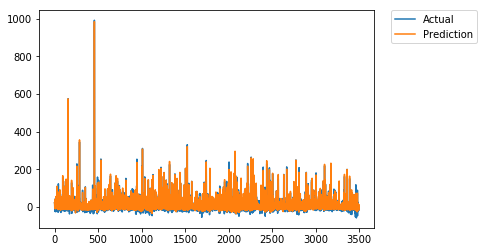

In [59]:
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['ArrDelay'],label='Actual')
#plt.plot(cv_prediction_sample_pd['id'] , cv_prediction_sample_pd['prediction'],label='CV_Prediction')
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['prediction'],label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()

In [60]:
training_df.count()

54932

#### กรองบาง Tuples (Records) ทิ้งไปจาก testing set

In [61]:
from pyspark.ml.evaluation import RegressionEvaluator

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null และผ่านการกรองฯ แล้ว

In [62]:
everesult_df = dtModel.transform(test_df.dropna())

In [63]:
lr_evaluator_r2 = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" \
      % lr_evaluator_r2.evaluate(everesult_df))

R Squared (R2) on test data = 0.940911


In [64]:
lr_evaluator_rmse = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" \
      % lr_evaluator_rmse.evaluate(everesult_df))

Root Mean Squared Error (RMSE) on test data = 9.34914


In [65]:
end_time = t.time()

In [66]:
(end_time-start_time)/60

0.631477971871694

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
dtModel.stages[7].getInputCols()

['UniqueCarrierIndexed',
 'OriginVec',
 'DepTimeIndexed',
 'TaxiOut',
 'TaxiIn',
 'DepDelay',
 'DayOfWeek',
 'Distance']

In [69]:
depdelay_pd = training_df.select('DepDelay').toPandas()

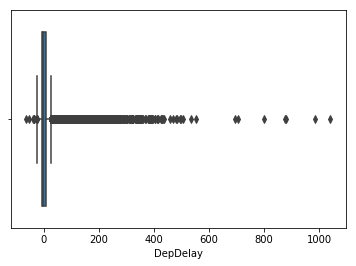

In [70]:
sns.boxplot(x=depdelay_pd["DepDelay"])

In [71]:
airline_row_df.withColumn('CRSElapsedTime',sparkf.col('CRSElapsedTime').cast(DoubleType()))\
.select('CRSElapsedTime').describe().show()

+-------+------------------+
|summary|    CRSElapsedTime|
+-------+------------------+
|  count|             68929|
|   mean|128.94909254450232|
| stddev| 69.41875657623864|
|    min|              15.0|
|    max|             660.0|
+-------+------------------+



In [72]:
CRSElapsedTime_pd = airline_row_df.withColumn('CRSElapsedTime',sparkf.col('CRSElapsedTime').cast(DoubleType()))\
.select('CRSElapsedTime').toPandas()

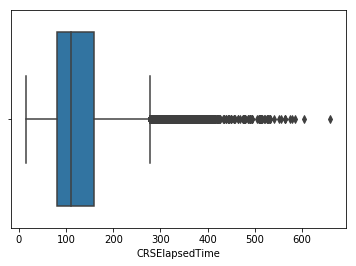

In [73]:
sns.boxplot(x=CRSElapsedTime_pd["CRSElapsedTime"])

In [74]:
airline_row_df.groupBy('Cancelled','CancellationCode','ArrDelay').count()\
.orderBy(sparkf.col('Cancelled').desc()).show(100)

+---------+----------------+--------+-----+
|Cancelled|CancellationCode|ArrDelay|count|
+---------+----------------+--------+-----+
|        0|            null|     114|   32|
|        0|            null|     263|    1|
|        0|            null|     402|    2|
|        0|            null|      -8| 2166|
|        0|            null|     160|   16|
|        0|            null|      39|  171|
|        0|            null|     185|    9|
|        0|            null|     357|    2|
|        0|            null|      14|  592|
|        0|            null|      51|  124|
|        0|            null|      82|   56|
|        0|            null|     325|    2|
|        0|            null|     308|    2|
|        0|            null|     326|    1|
|        0|            null|     -14| 1424|
|        0|            null|     207|    3|
|        0|            null|       8|  949|
|        0|            null|     149|   18|
|        0|            null|      97|   35|
|        0|            null|    

In [75]:
final_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
UniqueCarrier,68750,None,None,9E,YV
Origin,68750,None,None,ABE,YUM
Dest,68750,None,None,ABE,YUM
DepTime,68750,None,None,00.01-05.59,18.00-24.00
TaxiOut,68750,16.48994909090909,11.356613789489192,0.0,331.0
TaxiIn,68750,6.877425454545454,4.917131821023369,0.0,147.0
DepDelay,68750,9.903447272727274,35.37611614482617,-64.0,1040.0
DayOfWeek,68750,3.921847272727273,1.9833085998699238,1.0,7.0
Distance,68750,727.1956654545454,561.8439743372298,31.0,4962.0
